Telecom Customer Churn Prediction using Machine Learning and Deep Learning.
This script covers data preprocessing, class balancing, model training, evaluation, and model saving.

In [ ]:
import pandas as pd
import numpy as np

In [35]:
# Loading the churn dataset

df = pd.read_csv("/content/telecom_churn.csv")

In [36]:
# Converting values in 'date_of_registration' column to datetime and creating 'tenure_days' column for analysis

df['date_of_registration'] = pd.to_datetime(df['date_of_registration'])
df['tenure_days'] = (pd.Timestamp.today() - df['date_of_registration']).dt.days

# Ensuring no negative values in numerical features to maintain data integrity

df[['calls_made', 'sms_sent', 'data_used']] = df[['calls_made', 'sms_sent', 'data_used']].clip(lower=0)

In [37]:
# Displaying basic dataset info

print("Dataset Shape:", df.shape)
print("First 5 rows:\n", df.head())

Dataset Shape: (243553, 15)
First 5 rows:
    customer_id telecom_partner gender  age              state     city  \
0            1    Reliance Jio      F   25          Karnataka  Kolkata   
1            2    Reliance Jio      F   55            Mizoram   Mumbai   
2            3        Vodafone      F   57  Arunachal Pradesh    Delhi   
3            4            BSNL      M   46         Tamil Nadu  Kolkata   
4            5            BSNL      F   26            Tripura    Delhi   

   pincode date_of_registration  num_dependents  estimated_salary  calls_made  \
0   755597           2020-01-01               4            124962          44   
1   125926           2020-01-01               2            130556          62   
2   423976           2020-01-01               0            148828          49   
3   522841           2020-01-01               1             38722          80   
4   740247           2020-01-01               2             55098          78   

   sms_sent  data_used  c

In [ ]:
# Checking for missing values
df.isnull().sum()

,0
customer_id,0
telecom_partner,0
gender,0
age,0
state,0
city,0
pincode,0
date_of_registration,0
num_dependents,0
estimated_salary,0


In [ ]:
# Applying Label Encoding to convert categorical variables into numeric format
# Useful for algorithms that do not handle categorical data directly

from sklearn.preprocessing import LabelEncoder

categorical_cols = ['telecom_partner', 'gender', 'state', 'city']
label_encoders = {}

for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

In [ ]:
# Reducing skewness in feature distributions using log1p transformation
# Helps improve model performance and convergence

df[['calls_made', 'sms_sent', 'data_used', 'tenure_days']] = np.log1p(df[['calls_made', 'sms_sent', 'data_used', 'tenure_days']])

In [ ]:
# Dropping unnecessary columns to achieve better analysis

df.drop(columns=['customer_id', 'pincode', 'date_of_registration'], inplace=True, errors='ignore')

### 🧠 Feature Selection Rationale

- `calls_made`, `sms_sent`, `data_used`: Represent actual usage — essential for predicting churn. High or low usage could indicate dissatisfaction or high loyalty.
- `tenure_days`: Time since joining. Short-tenured users might be more prone to churn.
- `telecom_partner`, `gender`, `state`, `city`: Categorical data that could influence churn behavior based on demographics or location.

All features were retained except IDs and redundant fields like `pincode` or `date_of_registration` to avoid data leakage.

In [ ]:
# Defining features and target

X = df.drop('churn', axis = 1)
y = df['churn']

In [ ]:
# Addressing class imbalance using ADASYN (Adaptive Synthetic Sampling)
# Generates synthetic samples for the minority class

from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_balanced, y_balanced = adasyn.fit_resample(X, y)

In [ ]:
# Splitting the data into training and testing sets with stratification to preserve class ratio

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

In [ ]:
# Standardizing features for better performance with models like NN and XGBoost

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trainscaled, X_testscaled = scaler.fit_transform(X_train), scaler.transform(X_test)

In [ ]:
# Creating Neural Network Model with 10 hidden layers

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_trainscaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compiling the model

nn_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Using AdamW optimizer with weight decay to help prevent overfitting

In [ ]:
# EarlyStopping to prevent overfitting
# ReduceLROnPlateau to adjust learning rate dynamically

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
# Training the model

nn_model.fit(X_trainscaled, y_train, epochs=150, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping, lr_scheduler])

Epoch 1/150
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.6196 - loss: 0.6824 - val_accuracy: 0.6720 - val_loss: 0.6122 - learning_rate: 5.0000e-04
Epoch 2/150
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - accuracy: 0.6648 - loss: 0.6181 - val_accuracy: 0.6772 - val_loss: 0.6082 - learning_rate: 5.0000e-04
Epoch 3/150
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 72s 20ms/step - accuracy: 0.6718 - loss: 0.6130 - val_accuracy: 0.6818 - val_loss: 0.6025 - learning_rate: 5.0000e-04
Epoch 4/150
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.6771 - loss: 0.6056 - val_accuracy: 0.6848 - val_loss: 0.5994 - learning_rate: 5.0000e-04
Epoch 5/150
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.6791 - loss: 0.6051 - val_accuracy: 0.6863 - val_loss: 0.5982 - learning_rate: 5.0000e-04
Epoch 6/150
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.6816 - loss: 0.6033 - val_accuracy: 0.6883 - val_loss: 0.5962 - learning_rate: 5.0000e-04
Epoch 7/150
1953/1953 ━━━━━━━━━━━━

In [ ]:
# Predict NN
y_pred_probs_nn = nn_model.predict(X_testscaled).flatten()
y_pred_nn = (y_pred_probs_nn >= 0.5).astype(int)

2441/2441 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
# NN Evaluation
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report
print("Neural Network Evaluation")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_nn):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_probs_nn):.4f}")
print(classification_report(y_test, y_pred_nn))

Neural Network Evaluation
Accuracy: 0.7007
Balanced Accuracy: 0.7007
ROC AUC: 0.7609
              precision    recall  f1-score   support

           0       0.69      0.72      0.71     38945
           1       0.71      0.68      0.69     39145

    accuracy                           0.70     78090
   macro avg       0.70      0.70      0.70     78090
weighted avg       0.70      0.70      0.70     78090



In [ ]:
# Train other classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_trainscaled, y_train)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_trainscaled, y_train)

gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
gb_model.fit(X_trainscaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, n_estimators=200,
                           random_state=42)

In [ ]:
# Stacking Classifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
estimators = [('rf', rf_model), ('xgb', xgb_model), ('gb', gb_model)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stacking_model.fit(X_trainscaled, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_po...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=6,
                                                           n_estimators=200,
                                                           random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
# Evaluate Stacking
y_pred_stack = stacking_model.predict(X_testscaled)
print("\nStacking Classifier Evaluation")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_stack)}")
print(f"ROC AUC: {roc_auc_score(y_test, stacking_model.predict_proba(X_testscaled)[:,1])}")


Stacking Classifier Evaluation
Accuracy: 0.8090152388269944
Balanced Accuracy: 0.8091321229960321
ROC AUC: 0.8606832526181787


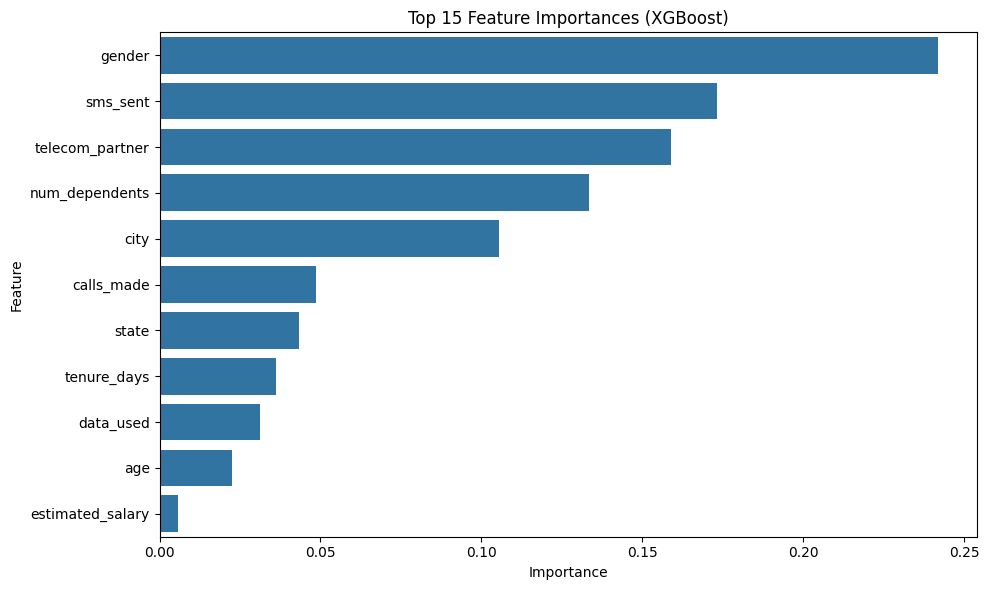

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance from XGBoost
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances[:15], y=xgb_importances.index[:15])
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

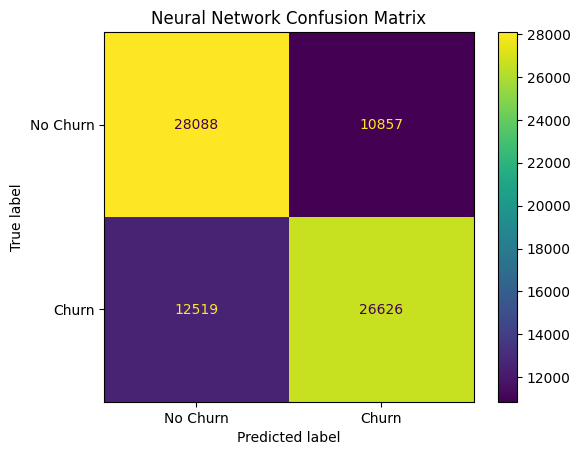

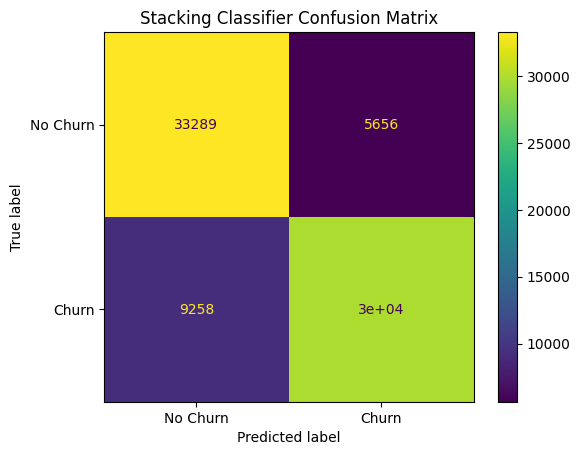

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# NN Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_nn), display_labels=["No Churn", "Churn"]).plot()
plt.title("Neural Network Confusion Matrix")
plt.show()

# Stacking Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stack), display_labels=["No Churn", "Churn"]).plot()
plt.title("Stacking Classifier Confusion Matrix")
plt.show()

In [38]:
# Save models
import pickle
nn_model.save("telecom_churn_nn_model_optimized.keras")
pickle.dump(scaler, open("scaler_optimized.pkl", "wb"))
pickle.dump(stacking_model, open("stacking_model.pkl", "wb"))

print("\nModels and Scaler saved successfully.")


Models and Scaler saved successfully.
